Hello Brian!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Initialize Libraries

In [1]:
# Statistical libraries
import pandas as pd
from scipy import stats as st
import numpy as np
from sklearn.metrics import *
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from pmdarima import auto_arima
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Graphing libraries
from matplotlib import pyplot as plt

### Look at Dataframe

In [ ]:
!zip -r 

In [2]:
# Read Dataframe
df_raw = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Quick look
df_raw.info()
display(df_raw.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


### Check for Duplicates, Monotonicity

In [4]:
# Duplicates?
display(df_raw.loc[df_raw.index.duplicated()])

,num_orders
datetime,


In [5]:
# Monotonicity?
print(df_raw.index.is_monotonic)

True


In [6]:
# Cleanup
df = df_raw.copy()
del df_raw

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Nice initial review.
</div>

### Resample to Hourly

In [7]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

### Determine AR / MA Orders and Number of Lags to Include

We will simply use the highest number that the AR lag analysis indicates to use when creating new lag features.

In [8]:
# AR Order
mod = ar_select_order(
    endog=df, 
    maxlag=30,
    trend='ct',
    seasonal=True,
    period=24,
    missing='drop'
)
ar_order = mod.ar_lags
print('AR ORDER:', ar_order)

# Determine best number of lags to include
best_lags = mod.ar_lags[-1]

AR ORDER: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


### Create Feature-based Dataframe

In [9]:
# Use data of series to create new features
df_expanded = df.copy()

# Create features
df_expanded['month'] = df_expanded.index.month
df_expanded['day'] = df_expanded.index.day
df_expanded['dayofweek'] = df_expanded.index.dayofweek
df_expanded['hour'] = df_expanded.index.hour

for lag in range(1, best_lags):
    df_expanded[('lag_' + str(lag))] = df_expanded['num_orders'].shift(lag)

df_expanded['rolling_mean'] = df_expanded['num_orders'].shift().rolling(best_lags).mean()

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Good job.
</div>

## Analysis

In [10]:
# Preliminary seasonal analysis
decomposed = seasonal_decompose(df)

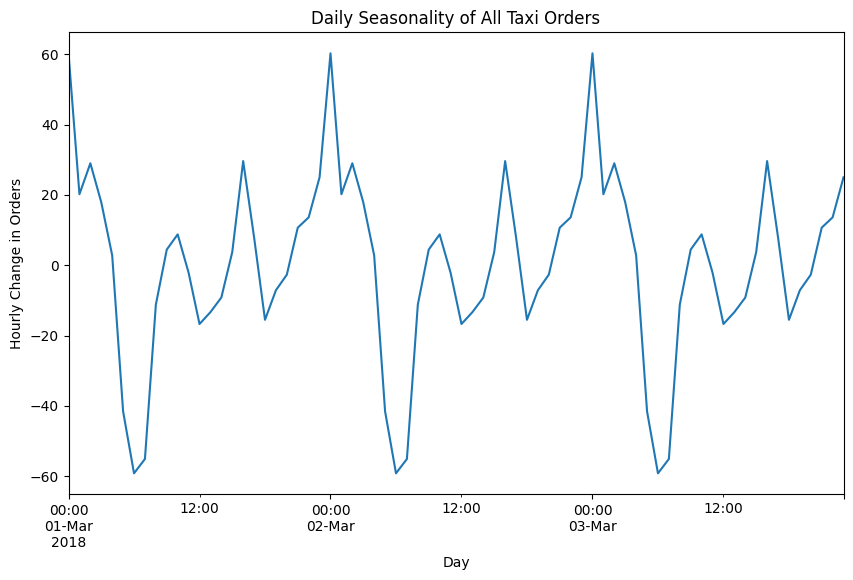

In [11]:
# Plot Daily Seasonality
plt.figure(figsize=(10,6))
decomposed.seasonal[:(3*24)].plot(ax=plt.gca())
plt.xlabel('Day')
plt.ylabel('Hourly Change in Orders')
plt.title('Daily Seasonality of All Taxi Orders')
plt.show()

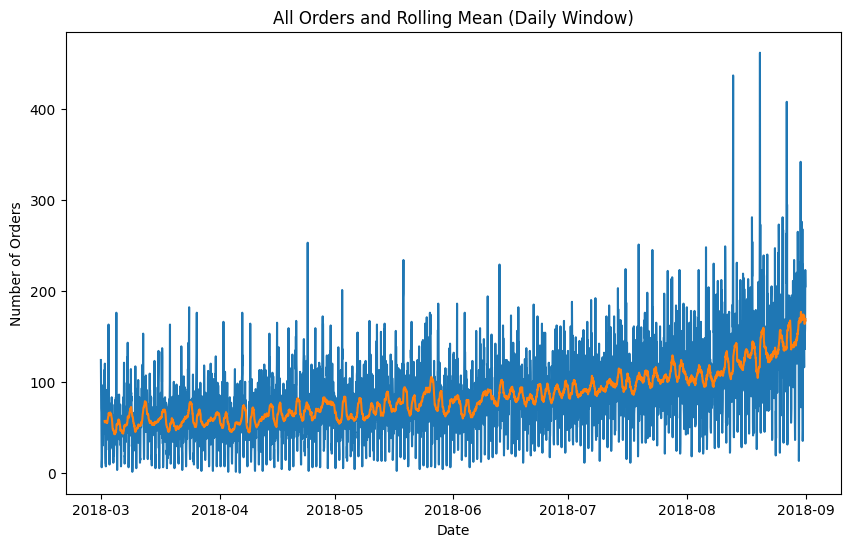

In [12]:
# Plot All Data w/ Rolling Mean
plt.figure(figsize=(10,6))
plt.plot(df_expanded['num_orders'])
plt.plot(df_expanded['rolling_mean'])
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('All Orders and Rolling Mean (Daily Window)')
plt.show()

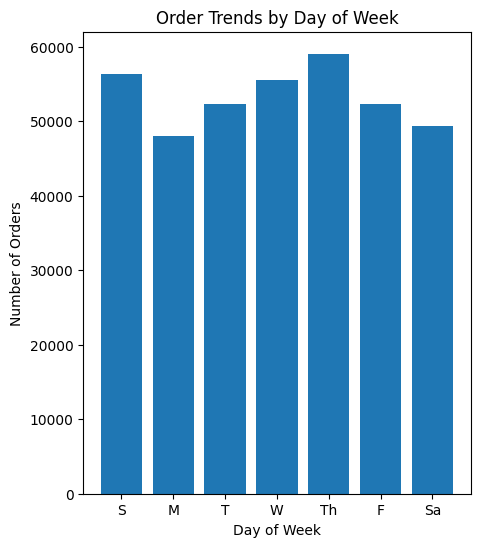

In [13]:
# Plot All Data w/ Rolling Mean
by_dow = df_expanded.groupby('dayofweek')['num_orders'].sum()

plt.figure(figsize=(5,6))
plt.bar(x=range(0, 7), height=by_dow)
plt.xlabel('Day of Week')
plt.xticks(ticks=range(0, 7), labels=['S', 'M', 'T', 'W', 'Th', 'F', 'Sa'])
plt.ylabel('Number of Orders')
plt.title('Order Trends by Day of Week')
plt.show()

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Nice graphs.
</div>

## Training

### Baseline Linear Regression

#### Split Into Train/Test Sets

In [14]:
# Split data to get a forecast horizon of 10% of the total data
features_train, features_test, target_train, target_test = train_test_split(
    df_expanded.drop(['num_orders'], axis=1), # features
    df_expanded['num_orders'], # target
    shuffle=False, 
    test_size=0.1
)

# Find NaN values in features_train and remove them, changing the indices of target_train to match
problem_indices = features_train[features_train.isna().any(axis=1)].index
features_train = features_train.drop(problem_indices)
target_train = target_train.drop(problem_indices)

#### Train Linear Regression

In [15]:
# Simply baseline Linear Regression
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

LinearRegression()

#### Evaluate

In [16]:
# Evaluate Linear Regression
lr_predict = lr_model.predict(features_test)
lr_rmse = mean_squared_error(target_test, lr_predict)**(1/2)

In [17]:
# Store lr predictions
lr_predictions = np.zeros(len(target_train) + len(target_test))
lr_predictions[:len(target_train)] = np.nan 
lr_predictions[len(target_train):] = lr_predict

# Store lr actual
lr_actual = np.zeros(len(target_train) + len(target_test))
lr_actual[:len(target_train)] = target_train
lr_actual[len(target_train):] = target_test

#### Cleanup to Conserve Resources

In [18]:
# Cleanup
del lr_model, features_train, features_test, target_train, target_test

### SARIMAX Model

Our model is nonstationary for certain, and thus we require an ARIMA model over a simple ARMA model. We will use the SARIMAX due to the clear daily seasonality to this hourly dataset.

#### Split Into Train/Valid/Test Sets

In [19]:
# Return train/test at ratio of 9:1
train, test = train_test_split(df, shuffle=False, test_size=0.1)

# Create tiny training set for determining best orders to prevent kernel from crashing
majority_train, minority_train = train_test_split(train, shuffle=False, test_size=0.111111)

#### Initialize

In [20]:
# SARIMAX Paramaters
sarimax_params = {
    'enforce_stationarity': False,
    'enforce_invertibility': False
}

# Ranges for p, d, q and seasonal P, D, Q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s = 24  # Daily seasonality

In [21]:
# Function to get best SARIMAX order hyperparams
def get_best_orders(train, p_range, d_range, q_range, P_range, D_range, Q_range, s):
    best_aic = 999999
    best_order = None
    best_seasonal_order = None

    for p in p_range:
        for d in d_values:
            for q in d_range:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                sarimax_model = SARIMAX(
                                    minority_train, 
                                    order=(p, d, q), 
                                    seasonal_order=(P, D, Q, s),
                                    **sarimax_params
                                )
                                sarimax_model_fit = sarimax_model.fit(disp=False)
                                if sarimax_model_fit.aic < best_aic:
                                    best_aic = sarimax_model_fit.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, s)
                            except:
                                continue
    return best_order, best_seasonal_order

#### Train SARIMAX

In [22]:
best_order, best_seasonal_order = get_best_orders(train, p_values, d_values, q_values, P_values, D_values, Q_values, s)

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Train the best SARIMA model and predict
sarimax_model = SARIMAX(
    train, 
    order = best_order, 
    seasonal_order = best_seasonal_order,
    **sarimax_params
)
sarimax_model = sarimax_model.fit(disp=False)

#### Evaluate

In [24]:
sarimax_pred = sarimax_model.forecast(steps=len(test))
sarimax_rmse = mean_squared_error(test, sarimax_pred)**(1/2)

In [25]:
# Store arima predictions
sarimax_predictions = np.zeros(len(df))
sarimax_predictions[:len(train)] = np.nan 
sarimax_predictions[len(train):] = sarimax_pred

# Store arima actual
sarimax_actual = np.array(df['num_orders'])

#### Cleanup to Conserve Resources

In [27]:
# Cleanup
del train, train_whole, test, majority_train, minority_train

NameError: name 'train' is not defined

### RandomForest Regression

#### Split Into Train/Valid/Test Sets

In [28]:
# Split data for hyperparameter tuning of train/valid/test at 9:1
features_train, features_test, target_train, target_test = train_test_split(
    df_expanded.drop(['num_orders'], axis=1), # features
    df_expanded['num_orders'], # target
    shuffle=False, 
    test_size=0.1
)

# Find NaN values in features_train and remove them, changing the indices of target_train to match
problem_indices = features_train[features_train.isna().any(axis=1)].index
features_train = features_train.drop(problem_indices)
target_train = target_train.drop(problem_indices)

#### Initialize

In [29]:
parameter_grid = {
    'n_estimators': [6, 10],
    'max_depth': [4, 6, 8],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [4, 6]
}
forest = RandomForestRegressor(
    random_state=12345, n_jobs = -1
)
cross_validator = KFold(
    n_splits=4, shuffle=True, random_state=12345
)
forest_GSCV = GridSearchCV(
    estimator=forest, param_grid=parameter_grid, scoring = 'neg_root_mean_squared_error', cv = cross_validator, verbose=3
)

#### Find Optimal Hyperparams and RF Model

In [30]:
# Random Forest Grid Search
forest_GSCV.fit(features_train, target_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV 1/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6; total time=   0.1s
[CV 2/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6; total time=   0.1s
[CV 3/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6; total time=   0.1s
[CV 4/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=6; total time=   0.1s
[CV 1/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.2s
[CV 2/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.2s
[CV 3/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.2s
[CV 4/4] END max_depth=4, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.2s
[CV 1/4] END max_depth=4, min_samples_leaf=4, min_samples_split=6, n_estimators=6; total time=   0.1s
[CV 2/4] END max_

[CV 2/4] END max_depth=8, min_samples_leaf=6, min_samples_split=4, n_estimators=6; total time=   0.2s
[CV 3/4] END max_depth=8, min_samples_leaf=6, min_samples_split=4, n_estimators=6; total time=   0.2s
[CV 4/4] END max_depth=8, min_samples_leaf=6, min_samples_split=4, n_estimators=6; total time=   0.2s
[CV 1/4] END max_depth=8, min_samples_leaf=6, min_samples_split=4, n_estimators=10; total time=   0.3s
[CV 2/4] END max_depth=8, min_samples_leaf=6, min_samples_split=4, n_estimators=10; total time=   0.3s
[CV 3/4] END max_depth=8, min_samples_leaf=6, min_samples_split=4, n_estimators=10; total time=   0.3s
[CV 4/4] END max_depth=8, min_samples_leaf=6, min_samples_split=4, n_estimators=10; total time=   0.3s
[CV 1/4] END max_depth=8, min_samples_leaf=6, min_samples_split=6, n_estimators=6; total time=   0.2s
[CV 2/4] END max_depth=8, min_samples_leaf=6, min_samples_split=6, n_estimators=6; total time=   0.2s
[CV 3/4] END max_depth=8, min_samples_leaf=6, min_samples_split=6, n_estimator

GridSearchCV(cv=KFold(n_splits=4, random_state=12345, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=12345),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6], 'n_estimators': [6, 10]},
             scoring='neg_root_mean_squared_error', verbose=3)

#### Evaluate

In [31]:
rf_model = RandomForestRegressor(
    random_state=12345, n_jobs=-1, **forest_GSCV.best_params_
)
rf_model.fit(features_train, target_train)
rf_predict = rf_model.predict(features_test)
rf_rmse = mean_squared_error(target_test, rf_predict)**(1/2)

In [32]:
# Store rf predictions
rf_predictions = np.zeros(len(target_train) + len(target_test))
rf_predictions[:len(target_train)] = np.nan 
rf_predictions[len(target_train):] = rf_predict

# Store rf actual
rf_actual = np.zeros(len(target_train) + len(target_test))
rf_actual[:len(target_train)] = target_train
rf_actual[len(target_train):] = target_test

#### Cleanup to Conserve Resources

In [33]:
del forest_GSCV, cross_validator, rf_model, forest, problem_indices, features_train, features_test, target_train, target_test

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Very good models training!
</div>

## Testing

### Evaluate Baseline (Linear Regression)

In [34]:
print('Linear Regression Model RMSE:')
print(lr_rmse)

Linear Regression Model RMSE:
45.81094888906941


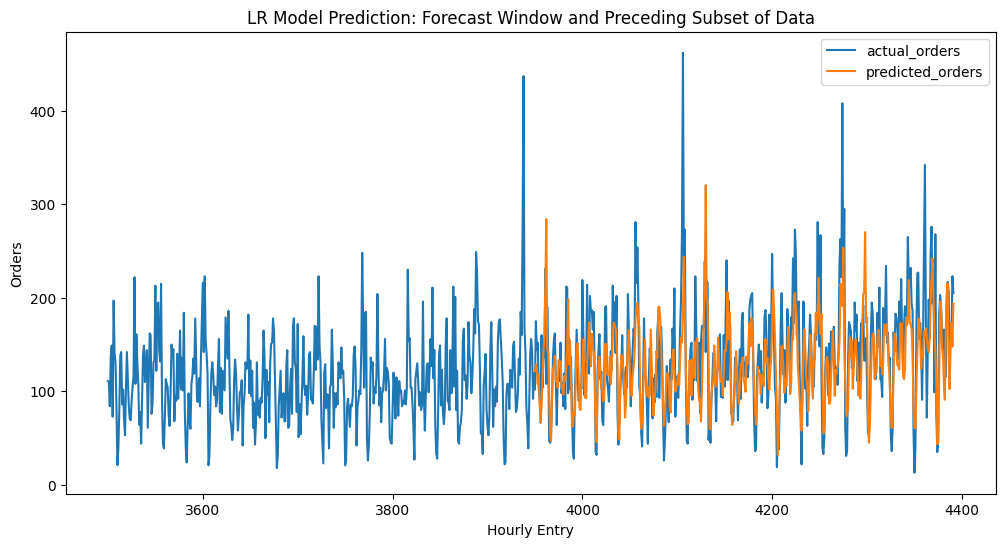

In [35]:
# Plottable dataframe
lr_plot_data = pd.DataFrame(
    {
        'actual_orders': lr_actual,
        'predicted_orders': lr_predictions
    }
)

# Plot
fig = plt.figure(figsize=(12,6))
lr_plot_data[3500:].plot(ax=plt.gca())
plt.xlabel('Hourly Entry')
plt.ylabel('Orders')
plt.title('LR Model Prediction: Forecast Window and Preceding Subset of Data')
plt.show()

### Evaluate Time Series Model (SARIMAX)

In [36]:
print('SARIMAX Model RMSE:')
print(sarimax_rmse)

SARIMAX Model RMSE:
45.16813688203869


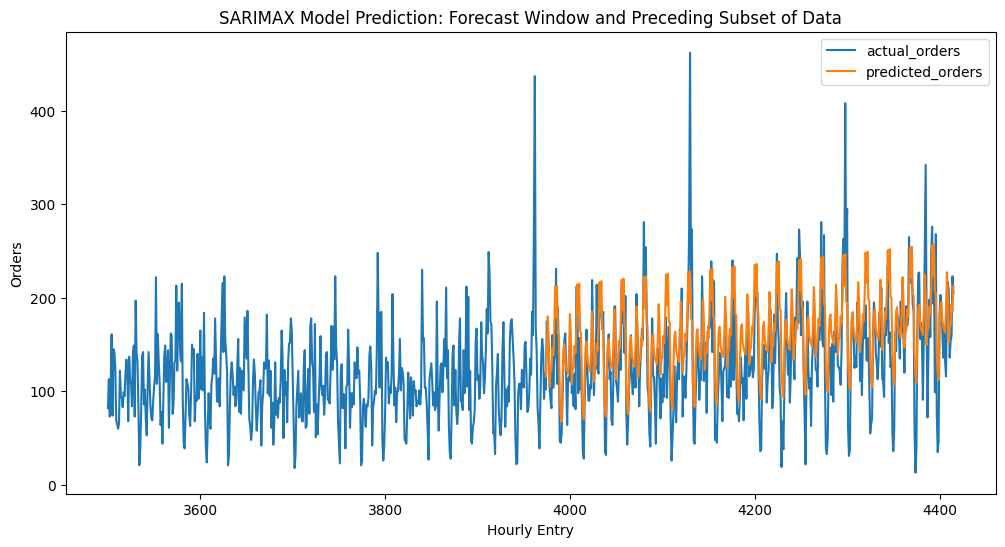

In [37]:
# Plottable dataframe
sarimax_plot_data = pd.DataFrame(
    {
        'actual_orders': sarimax_actual,
        'predicted_orders': sarimax_predictions
    }
)

# Plot
fig = plt.figure(figsize=(12,6))
sarimax_plot_data[3500:].plot(ax=plt.gca())
plt.xlabel('Hourly Entry')
plt.ylabel('Orders')
plt.title('SARIMAX Model Prediction: Forecast Window and Preceding Subset of Data')
plt.show()

### Evaluate Random Forest Regression

In [38]:
print('Random Forest Regression Model RMSE:')
print(rf_rmse)

Random Forest Regression Model RMSE:
46.21399886662175


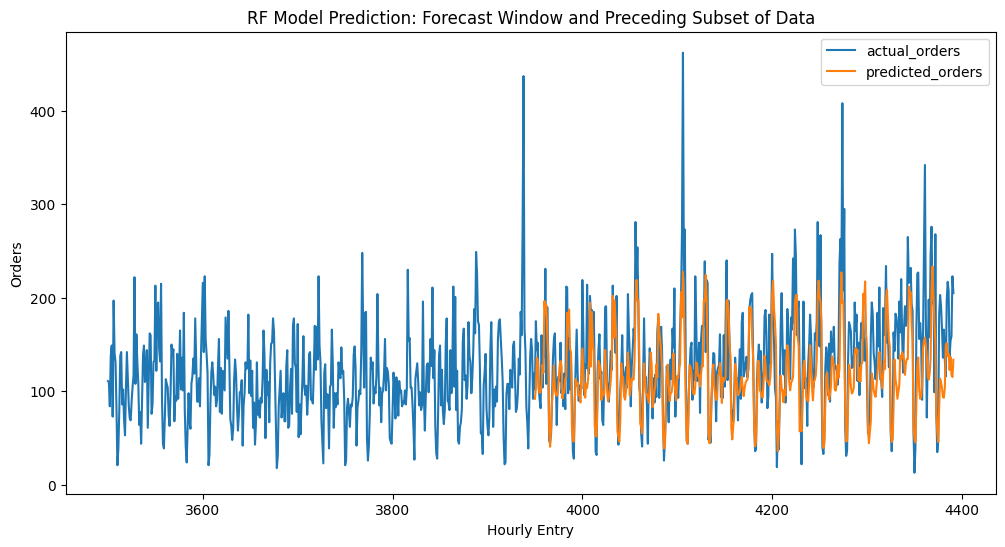

In [39]:
# Plottable dataframe
rf_plot_data = pd.DataFrame(
    {
        'actual_orders': rf_actual,
        'predicted_orders': rf_predictions
    }
)

# Plot
fig = plt.figure(figsize=(12,6))
rf_plot_data[3500:].plot(ax=plt.gca())
plt.xlabel('Hourly Entry')
plt.ylabel('Orders')
plt.title('RF Model Prediction: Forecast Window and Preceding Subset of Data')
plt.show()

#### Conclusion

When tuning the Linear Regression and Random Forest models, we used an expanded dataframe that took into account datetime features and 24 lag-value-adjusted features. The SARIMAX model relied on the simple time series of the 'num_orders' column. For all models our prediction window was the final 10% of the dataset, or the final 18 days of the set. The above graphs plot the actual values against the model predictions for this final window.

All three models had comparable RMSE values around 45. The lowest was SARIMAX at 45.168137. This indicates that accounting more heavily on 24-hour seasonality is an advantage.

The Linear Regression and Random Forest models were quick to train and performed well despite not taking AR or MA modeling into account.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

We gor RMSE < 48! Excellent!
</div>

<div class="alert alert-block alert-success">
<b>Overall reviewer's comment</b> <a class="tocSkip"></a>

Thank you for sending your project. You've done a really good job on it!
    
Especially impressed:

- deep detailed conclusions
    
- good graphs
    
- high code level

- good project structure
    
    
Thank you for in-depth analysis and logical conclusions!
    
I'm glad to say that your project has been accepted. Keep up the good work and good luck on the next sprint!
</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48